#### Convex term project: ADMM-Image Denoising
#### Spring2025
#### Jingyi Wang, Yuning Zhuang

#### Notebook Introduction: 
In this notebook, ADMM-the Alternating Direction Method of Multipliers method is implemented to a TV(total variant) regularized image denoising prolem. The chosen image is the typical figure "Lena.jpg". The gaussian noises are added to the picture and ADMM is using to help denoising the noisy picture.

### 1. Set up: prepare the noisy image and helper functions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request
# import psnr here
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Download and load Lena image ---
url = 'https://github.com/opencv/opencv/raw/master/samples/data/lena.jpg'
urllib.request.urlretrieve(url, 'lena.jpg')

# Load as grayscale and normalize to the range [0, 1]
# Named image3 cuz had several testing drafts before
image3 = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Add Gaussian noise
np.random.seed(0)
noisy = image3 + np.random.normal(0, 0.1, image3.shape)
noisy = np.clip(noisy, 0, 1)

# --- Helper Functions ---
# gradient
# Computes finite difference gradient in both directions (x = horizontal, y = vertical), for TV use
def grad(u):
    ux = np.zeros_like(u)
    uy = np.zeros_like(u)
    ux[:, :-1] = np.diff(u, axis=1)
    uy[:-1, :] = np.diff(u, axis=0)
    return ux, uy

# divergence
# Used in the u-update to combine directional information
def div(px, py):
    tx = np.zeros_like(px)
    ty = np.zeros_like(py)
    tx[:, 1:] = px[:, 1:] - px[:, :-1]
    ty[1:, :] = py[1:, :] - py[:-1, :]
    tx[:, 0] = px[:, 0]
    ty[0, :] = py[0, :]
    return tx + ty

# Implements the TV proximal operator (soft thresholding in 2D)
def shrink(x, y, kappa):
    s = np.sqrt(x**2 + y**2)
    scale = np.maximum(s - kappa, 0) / (s + 1e-10)
    return scale * x, scale * y

# Efficiently solves a quadratic subproblem in the frequency domain using FFT.
# Comes from minimizing the squared fidelity term plus a divergence term from ADMM updates
# Prepare to use in the u-update step of ADMM
Used in the u-update step of ADMM.
def solve_u(noisy, div_pb, rho):
    m, n = noisy.shape
    wx = 2 * np.pi * np.fft.fftfreq(n)
    wy = 2 * np.pi * np.fft.fftfreq(m)
    WX, WY = np.meshgrid(wx, wy)
    denom = 1 + rho * (4 - 2 * np.cos(WX) - 2 * np.cos(WY))

    noisy_fft = np.fft.fft2(noisy)
    div_fft = np.fft.fft2(div_pb)
    u_fft = (noisy_fft + rho * div_fft) / denom
    u = np.real(np.fft.ifft2(u_fft))
    return u

### 2. ADMM-TV Denosing

In [3]:
# --- ADMM-TV Denoising ---

# Define ADMM-TV
# Parameters: noisy image, original image, lambd-regularization parameter that controls strength of TV, 
# rho-augmented Lagrangian penalty, iteration times
def tv_denoise_ADMM(noisy, original, lambd, rho, num_iter):
    # Initialization: 
    # u: denoised image (starting from noisy image)
    u = noisy.copy()
    
    # px, py: dual variables (gradient proxies for v)
    # bx, by: rescaled Lagrange multipliers
    px = np.zeros_like(u)
    py = np.zeros_like(u)
    bx = np.zeros_like(u)
    by = np.zeros_like(u)

    psnr_history = []
    
    # ADMM work here:
    # Divergence step to prepare input to u solver
    # u-update: solves a least-squares problem using FFT
    # Gradient step: compute ux, uy
    # v-update (TV prox) via shrink operator
    # Dual variable update (bx, by) tracks disagreement between u and v
    # Clipping to keep pixel values valid
    # PSNR tracking for monitoring convergence
    for i in range(num_iter):
        div_pb = div(px - bx, py - by)
        u = solve_u(noisy, div_pb, rho)
        ux, uy = grad(u)
        px, py = shrink(ux + bx, uy + by, lambd / rho)
        bx += ux - px
        by += uy - py
        
        # ensure the pixel value still in [0,1] range
        u = np.clip(u, 0, 1)

        current_psnr = psnr(original, u, data_range=1.0)
        psnr_history.append(current_psnr)

    return u, psnr_history

#### Denoising result of implementing ADMM

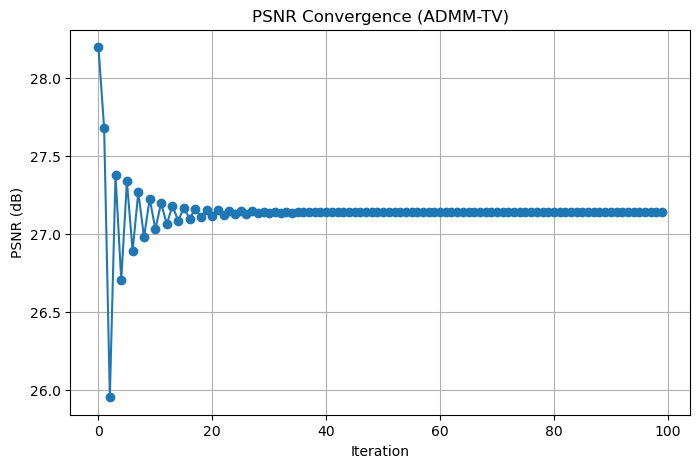

/var/folders/1b/zznb8wm940383dcw1_qxlls40000gn/T/ipykernel_278/2860007920.py:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title(f'Noisy\nPSNR={psnr(image3, noisy):.2f} dB')


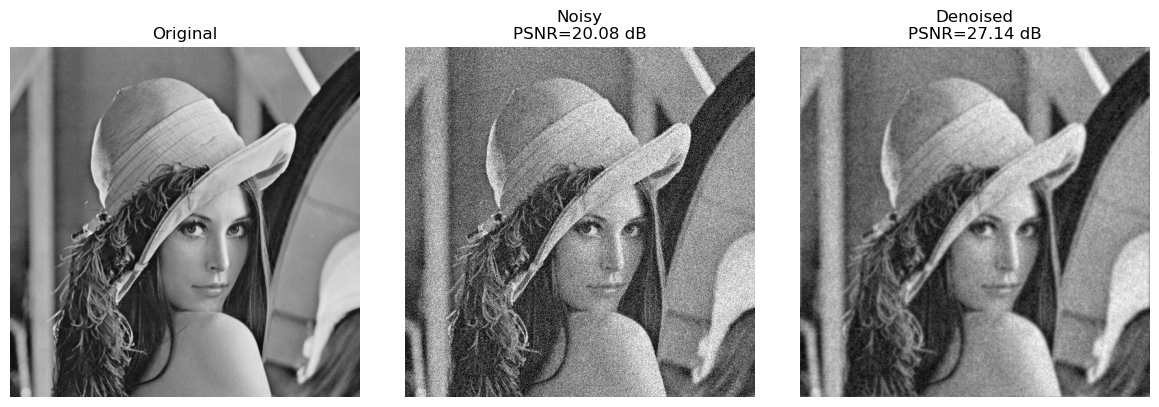

Initial PSNR (noisy): 20.08 dB
Final PSNR (denoised): 27.14 dB


/var/folders/1b/zznb8wm940383dcw1_qxlls40000gn/T/ipykernel_278/2860007920.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"Initial PSNR (noisy): {psnr(image3, noisy):.2f} dB")


In [18]:
# Setting parameters
lambd = 0.15
rho = 2.0
# iteration times, set all methods to 100
num_iter = 100

denoised, psnr_history = tv_denoise_ADMM(noisy, image3, lambd, rho, num_iter)

# --- Plot PSNR Curve ---
plt.figure(figsize=(8, 5))
plt.plot(psnr_history, marker='o')
plt.title('PSNR Convergence (ADMM-TV)')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

# --- Show Images Result---
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(image3, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(noisy, cmap='gray')
plt.title(f'Noisy\nPSNR={psnr(image3, noisy):.2f} dB')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised, cmap='gray')
plt.title(f'Denoised\nPSNR={psnr_history[-1]:.2f} dB')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Final PSNR Output ---
print(f"Initial PSNR (noisy): {psnr(image3, noisy):.2f} dB")
print(f"Final PSNR (denoised): {psnr_history[-1]:.2f} dB")


### 3. Comapre with Gaussian

In [5]:
from skimage.metrics import structural_similarity as ssim

# Gaussian smoothing baseline
gaussian_denoised = cv2.GaussianBlur(noisy, (5, 5), sigmaX=1.0)

# Compute PSNR and SSIM
psnr_gaussian = psnr(image3, gaussian_denoised, data_range=1.0)
ssim_gaussian = ssim(image3, gaussian_denoised, data_range=1.0)
psnr_admm = psnr(image3, denoised, data_range=1.0)
ssim_admm = ssim(image3, denoised, data_range=1.0)

# Print results
print(f"[Gaussian Smoothing] PSNR: {psnr_gaussian:.2f} dB, SSIM: {ssim_gaussian:.4f}")
print(f"[ADMM-TV Denoising ] PSNR: {psnr_admm:.2f} dB, SSIM: {ssim_admm:.4f}")


[Gaussian Smoothing] PSNR: 28.86 dB, SSIM: 0.7033
[ADMM-TV Denoising ] PSNR: 27.14 dB, SSIM: 0.6407


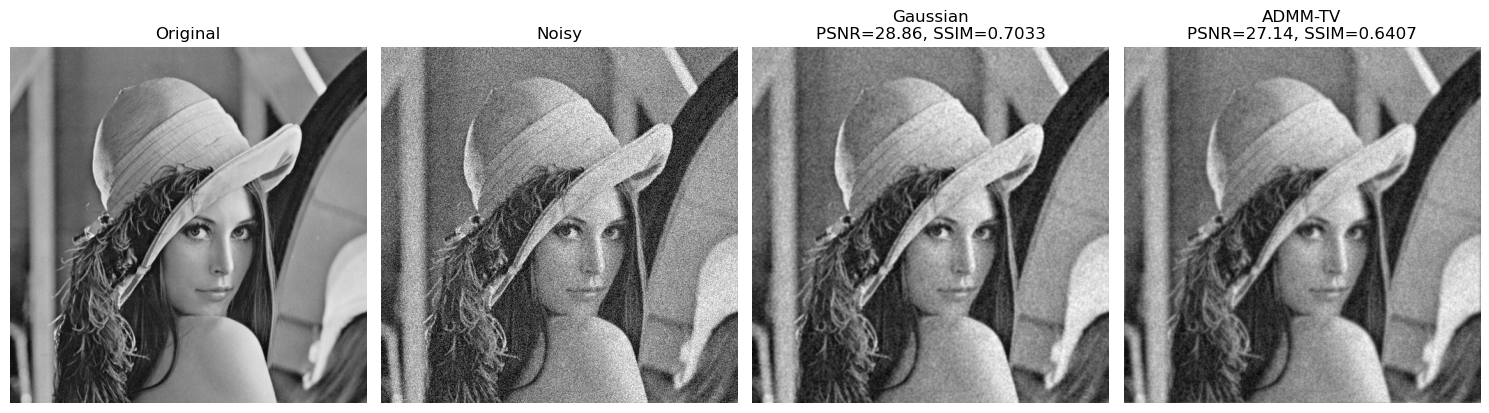

In [6]:
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.imshow(image3, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(142)
plt.imshow(noisy, cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.subplot(143)
plt.imshow(gaussian_denoised, cmap='gray')
plt.title(f"Gaussian\nPSNR={psnr_gaussian:.2f}, SSIM={ssim_gaussian:.4f}")
plt.axis('off')

plt.subplot(144)
plt.imshow(denoised, cmap='gray')
plt.title(f"ADMM-TV\nPSNR={psnr_admm:.2f}, SSIM={ssim_admm:.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()


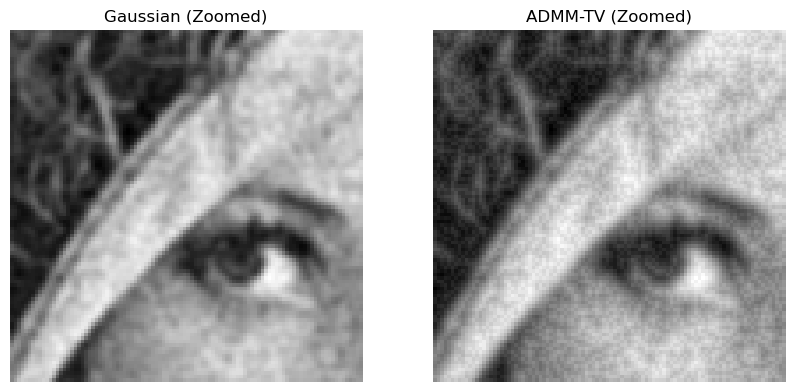

In [7]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gaussian_denoised[200:300, 200:300], cmap='gray')
plt.title('Gaussian (Zoomed)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised[200:300, 200:300], cmap='gray')
plt.title('ADMM-TV (Zoomed)')
plt.axis('off')
plt.show()


In [6]:
# remove
# Try more aggressive regularization and more iterations
# lambd = 0.2     # more noise suppression
# rho = 2.0
# num_iter = 150  # allow better convergence


In [9]:
# an update function in case want to try new parameters
denoised_updated, psnr_history_updated = tv_denoise_ADMM(noisy, image3, lambd, rho, num_iter)


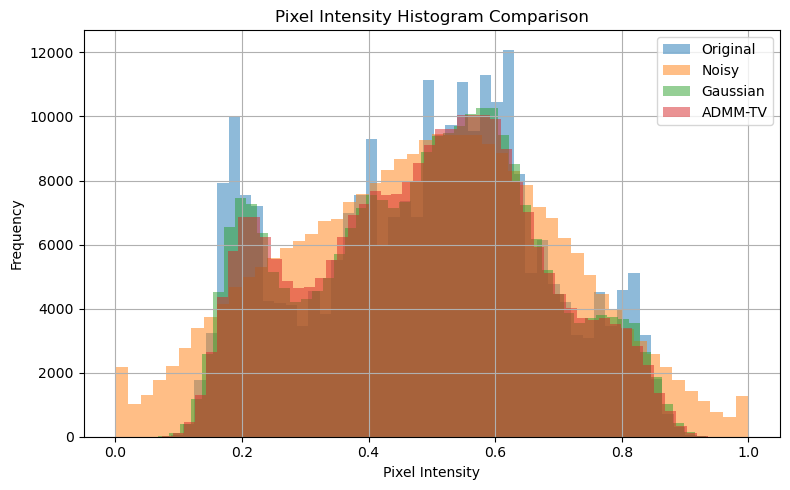

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(image3.ravel(), bins=50, alpha=0.5, label='Original')
plt.hist(noisy.ravel(), bins=50, alpha=0.5, label='Noisy')
plt.hist(gaussian_denoised.ravel(), bins=50, alpha=0.5, label='Gaussian')
plt.hist(denoised_updated.ravel(), bins=50, alpha=0.5, label='ADMM-TV')
plt.title("Pixel Intensity Histogram Comparison")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Since Gaussian works better, trying to check if it really works that well

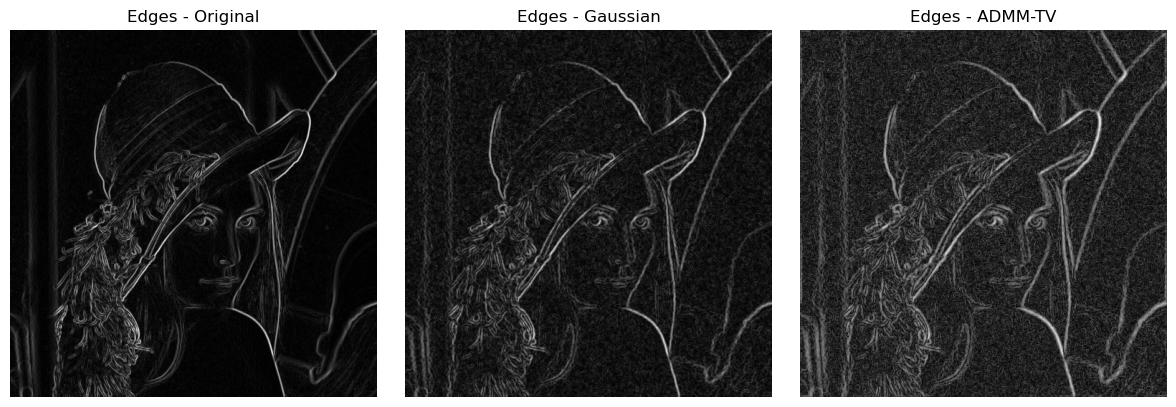

In [11]:
from skimage.filters import sobel

edge_orig = sobel(image3)
edge_gaussian = sobel(gaussian_denoised)
edge_admm = sobel(denoised_updated)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(edge_orig, cmap='gray')
plt.title("Edges - Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(edge_gaussian, cmap='gray')
plt.title("Edges - Gaussian")
plt.axis('off')

plt.subplot(133)
plt.imshow(edge_admm, cmap='gray')
plt.title("Edges - ADMM-TV")
plt.axis('off')

plt.tight_layout()
plt.show()


### 4. Compare with Median Filter Method

In [12]:
from scipy.ndimage import median_filter

median_denoised = median_filter(noisy, size=3)

psnr_median = psnr(image3, median_denoised, data_range=1.0)
ssim_median = ssim(image3, median_denoised, data_range=1.0)

print(f"[Median Filter] PSNR: {psnr_median:.2f} dB, SSIM: {ssim_median:.4f}")


[Median Filter] PSNR: 26.77 dB, SSIM: 0.5741


### 5. Compare with FISTA Method

In [13]:

# same 
def grad_img(u):
    ux = np.zeros_like(u)
    uy = np.zeros_like(u)
    ux[:, :-1] = np.diff(u, axis=1)
    uy[:-1, :] = np.diff(u, axis=0)
    return ux, uy

# t, y: momentum-based extrapolation (accelerates convergence)
def div_img(px, py):
    tx = np.zeros_like(px)
    ty = np.zeros_like(py)
    tx[:, 1:] = px[:, 1:] - px[:, :-1]
    ty[1:, :] = py[1:, :] - py[:-1, :]
    tx[:, 0] = px[:, 0]
    ty[0, :] = py[0, :]
    return tx + ty

#  FIXED prox_tv using Chambolle's algorithm
#  applies the TV-regularized step
def prox_tv(u, lmbd, n_iter=30):
    m, n = u.shape
    px = np.zeros_like(u)
    py = np.zeros_like(u)
    # step size for projection
    taut = 0.125  

    for _ in range(n_iter):
        div_p = div_img(px, py)
        dx, dy = grad_img(div_p - u / lmbd)
        norm = np.maximum(1.0, np.sqrt(dx**2 + dy**2))
        px = (px + taut * dx) / norm
        py = (py + taut * dy) / norm

    return u - lmbd * div_img(px, py)

# FISTA-TV with fixed prox
def fista_tv_denoising(f, lmbd=0.15, step=0.25, n_iter=100, original=None):
    x = f.copy()
    y = f.copy()
    t = 1
    psnr_list = []

    for i in range(n_iter):
        grad = y - f
        x_new = prox_tv(y - step * grad, lmbd * step)
        x_new = np.clip(x_new, 0, 1)

        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)

        x = x_new
        t = t_new

        if original is not None:
            psnr_list.append(psnr(original, x, data_range=1.0))

    return x, psnr_list


In [14]:
denoised_fista, psnr_fista = fista_tv_denoising(noisy, lmbd=0.15, step=0.25, n_iter=100, original=image3)
# Run ADMM-TV (from earlier)
#denoised_admm, psnr_admm = tv_denoise_ADMM(noisy, image3, lambd=0.15, rho=2.0, num_iter=100)
denoised_admm, psnr_admm = tv_denoise_ADMM(noisy, image3, 0.15, 2.0, 100)

print(f"[ADMM-TV ] PSNR: {psnr_admm[-1]:.2f}")
print(f"[FISTA-TV] PSNR: {psnr_fista[-1]:.2f}")


[ADMM-TV ] PSNR: 27.14
[FISTA-TV] PSNR: 25.72


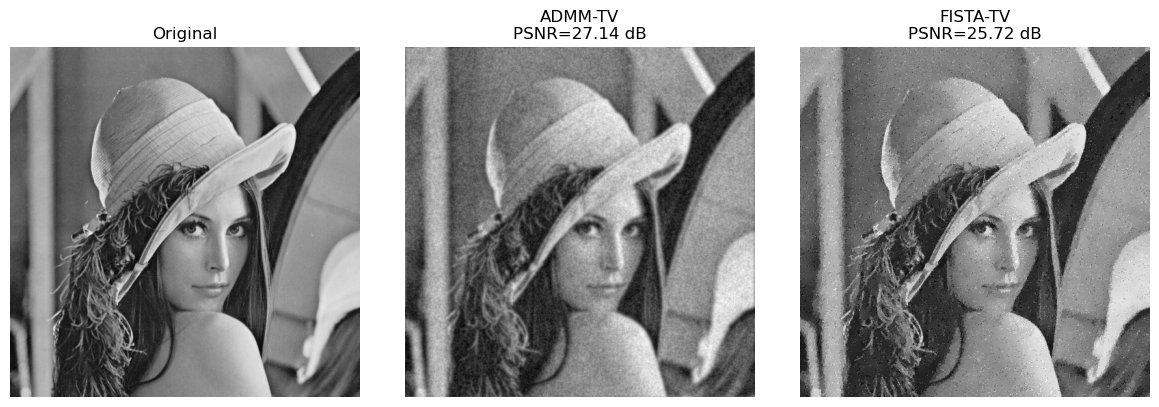

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(image3, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised_admm, cmap='gray')
plt.title(f"ADMM-TV\nPSNR={psnr_admm[-1]:.2f} dB")
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_fista, cmap='gray')
plt.title(f"FISTA-TV\nPSNR={psnr_fista[-1]:.2f} dB")
plt.axis('off')

plt.tight_layout()
plt.show()


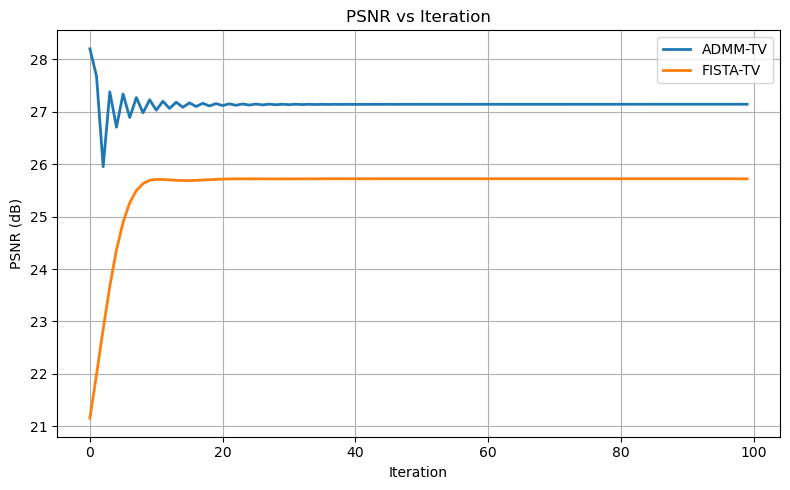

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(psnr_admm, label="ADMM-TV", linewidth=2)
plt.plot(psnr_fista, label="FISTA-TV", linewidth=2)
plt.title("PSNR vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from skimage.metrics import structural_similarity as ssim

ssim_admm = ssim(image3, denoised_admm, data_range=1.0)
ssim_fista = ssim(image3, denoised_fista, data_range=1.0)

print(f"[ADMM-TV ] SSIM: {ssim_admm:.4f}")
print(f"[FISTA-TV] SSIM: {ssim_fista:.4f}")


[ADMM-TV ] SSIM: 0.6407
[FISTA-TV] SSIM: 0.5455


#### Reference
[1] Gonzalez, R.C. and Woods, R.E. (2018) Digital Image Processing. 4th Edition, Pearson Education, New York, 1022 p.

[2] A. Beck and M. Teboulle, ”A fast Iterative Shrinkage-Thresholding Al- gorithm with application to wavelet-based image deblurring,” 2009 IEEE International Conference on Acoustics, Speech and Signal Processing, Taipei, 2009, pp. 693-696, doi: 10.1109/ICASSP.2009.4959678.

[3] "How to actually implement ADMM on TV problem" prompt, ChatGPT (4o), April 27. OpenAI, chat.openai.com

[4] "How to actually implement FISTA on TV problem" prompt, ChatGPT (4o), April 27. OpenAI, chat.openai.com